In [1]:
!pip install pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 5.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from kan import KAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
BENCHMARKS = [
    # --- Elliptic ---
    dict(
        name="Jacobian elliptic",
        scipy_name="ellipj",
        func=lambda x: scipy.special.ellipj(x[:,0], x[:,1])[0],
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,3,2,1,1,1],
    ),
    dict(
        name="Elliptic integral (1st kind)",
        scipy_name="ellipkinc",  # Fixed: was "ellipinc"
        func=lambda x: scipy.special.ellipkinc(x[:,0], x[:,1]),  # Fixed
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,2,1,1,1],
    ),
    dict(
        name="Elliptic integral (2nd kind)",
        scipy_name="ellipeinc",
        func=lambda x: scipy.special.ellipeinc(x[:,0], x[:,1]),
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,2,1,1],
    ),
    # --- Bessel ---
    dict(
        name="Bessel J",
        scipy_name="jv",
        func=lambda x: scipy.special.jv(x[:,0], x[:,1]),
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,3,1,1,1],
    ),
    dict(
        name="Bessel Y",
        scipy_name="yv",
        func=lambda x: scipy.special.yv(x[:,0], x[:,1]),
        input_dim=2,
        kan_min=[2,3,1],
        kan_best=[2,2,2,1],
    ),
    # --- Modified Bessel ---
    dict(
        name="Modified Bessel K",
        scipy_name="kv",
        func=lambda x: scipy.special.kv(x[:,0], x[:,1]),
        input_dim=2,
        kan_min=[2,1,1],
        kan_best=[2,2,1],
    ),
    dict(
        name="Modified Bessel I",
        scipy_name="iv",
        func=lambda x: scipy.special.iv(x[:,0], x[:,1]),
        input_dim=2,
        kan_min=[2,4,3,2,1],
        kan_best=[2,4,3,2,1],
    ),
    # --- Associated Legendre ---
    dict(
        name="Legendre m=0",
        scipy_name="lpmv",
        func=lambda x: scipy.special.lpmv(0, x[:,0], x[:,1]),
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,2,1],
    ),
    dict(
        name="Legendre m=1",
        scipy_name="lpmv",
        func=lambda x: scipy.special.lpmv(1, x[:,0], x[:,1]),
        input_dim=2,
        kan_min=[2,4,1],
        kan_best=[2,4,1],
    ),
    dict(
        name="Legendre m=2",
        scipy_name="lpmv",
        func=lambda x: scipy.special.lpmv(2, x[:,0], x[:,1]),
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,3,2,1],
    ),
    # --- Spherical harmonics ---
    dict(
        name="Sph harm (0,1)",
        scipy_name="sph_harm",
        func=lambda x: scipy.special.sph_harm(0, 1, x[:,0], x[:,1]).real,
        input_dim=2,
        kan_min=[2,1,1],
        kan_best=[2,1,1],
    ),
    dict(
        name="Sph harm (1,1)",
        scipy_name="sph_harm",
        func=lambda x: scipy.special.sph_harm(1, 1, x[:,0], x[:,1]).real,
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,3,2,1],
    ),
    dict(
        name="Sph harm (0,2)",
        scipy_name="sph_harm",
        func=lambda x: scipy.special.sph_harm(0, 2, x[:,0], x[:,1]).real,
        input_dim=2,
        kan_min=[2,1,1],
        kan_best=[2,1,1],
    ),
    dict(
        name="Sph harm (1,2)",
        scipy_name="sph_harm",
        func=lambda x: scipy.special.sph_harm(1, 2, x[:,0], x[:,1]).real,
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,2,1,1],
    ),
    dict(
        name="Sph harm (2,2)",
        scipy_name="sph_harm",
        func=lambda x: scipy.special.sph_harm(2, 2, x[:,0], x[:,1]).real,
        input_dim=2,
        kan_min=[2,2,1],
        kan_best=[2,2,3,2,1],
    ),
]

In [4]:
def get_data(benchmark, n=1000):
    """Generate data with NaN filtering and proper bounds"""
    name = benchmark["name"]
    
    # Generate more samples initially to account for filtering
    n_initial = int(n * 1.5)
    
    if "Jacobian elliptic" in name:
        u = torch.rand(n_initial, 1) * 4.0        # u ∈ [0,4]
        m = torch.rand(n_initial, 1) * 0.99       # m ∈ [0,0.99] avoid m=1
        x = torch.cat([u, m], dim=1)
    elif "Elliptic integral" in name:
        # For elliptic integrals: phi (angle) and m (parameter)
        phi = torch.rand(n_initial, 1) * np.pi/2  # phi ∈ [0, π/2]
        m = torch.rand(n_initial, 1) * 0.99       # m ∈ [0,0.99] avoid m=1
        x = torch.cat([phi, m], dim=1)
    elif "Bessel" in name:
        v = torch.rand(n_initial, 1) * 5.0        # order
        z = torch.rand(n_initial, 1) * 5.0 + 0.1  # argument > 0
        x = torch.cat([v, z], dim=1)
    elif "Legendre" in name:
        l = torch.rand(n_initial, 1) * 5.0
        z = torch.rand(n_initial, 1) * 2.0 - 1.0  # |z| ≤ 1
        x = torch.cat([l, z], dim=1)
    elif "Sph harm" in name:
        theta = torch.rand(n_initial, 1) * 2 * np.pi
        phi = torch.rand(n_initial, 1) * np.pi
        x = torch.cat([theta, phi], dim=1)
    else:
        raise ValueError("Unknown benchmark")
    
    # Compute target values
    with torch.no_grad():
        y_np = benchmark["func"](x.numpy())
        y = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)
        
        # Filter out NaN and Inf values
        valid_mask = torch.isfinite(y).squeeze() & torch.isfinite(x).all(dim=1)
        x = x[valid_mask]
        y = y[valid_mask]
        
        # Take only n samples
        if len(x) > n:
            indices = torch.randperm(len(x))[:n]
            x = x[indices]
            y = y[indices]
        
        if len(x) == 0:
            raise ValueError(f"No valid samples for {name}")
        
        print(f"Generated {len(x)} valid samples for {name}")
        print(f"Y range: [{y.min():.3f}, {y.max():.3f}]")
    
    return x.to(device), y.to(device)

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self, d, w, depth):
        super().__init__()
        layers = [nn.Linear(d, w), nn.ReLU()]
        for _ in range(depth - 2):
            layers += [nn.Linear(w, w), nn.ReLU()]
        layers.append(nn.Linear(w, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [6]:
def train_kan(benchmark, use_best=False):
    xtr, ytr = get_data(benchmark)
    xte, yte = get_data(benchmark)

    shape = benchmark["kan_best"] if use_best else benchmark["kan_min"]
    grids = [3, 5, 10, 20, 50, 100]

    dataset = {
        "train_input": xtr,
        "train_label": ytr,
        "test_input": xte,
        "test_label": yte,
    }

    model = KAN(width=shape, grid=grids[0], k=3, seed=0, device=device)

    params, rmses = [], []

    for g in grids:
        if g != grids[0]:
            model = model.refine(g)

        model.fit(dataset, opt="LBFGS", steps=200, lamb = 0.01)

        pred = model(xte)
        rmse = torch.sqrt(torch.mean((pred - yte)**2)).item()

        params.append(sum(p.numel() for p in model.parameters()))
        rmses.append(rmse)

        print(f"{benchmark['name']} | grid {g} | RMSE {rmse:.2e}")

    return params, rmses


In [7]:
def train_kan_shape(benchmark, shape, label):
    print(f"\n--- Training {label} for {benchmark['name']} ---")
    xtr, ytr = get_data(benchmark, n=1000)
    xte, yte = get_data(benchmark, n=1000)
    
    # Normalization
    x_mean = xtr.mean(dim=0, keepdim=True)
    x_std  = xtr.std(dim=0, keepdim=True) + 1e-8
    y_mean = ytr.mean()
    y_std  = ytr.std() + 1e-8
    xtr = (xtr - x_mean) / x_std
    ytr = (ytr - y_mean) / y_std
    xte = (xte - x_mean) / x_std
    yte = (yte - y_mean) / y_std
    
    grids = [3, 5, 10, 20, 50, 100]
    dataset = {
        "train_input": xtr,
        "train_label": ytr,
        "test_input": xte,
        "test_label": yte,
    }
    
    params, rmses = [], []
    for g in grids:
        print(f"  Grid = {g}")
        try:
            model = KAN(
                width=shape,
                grid=g,
                k=3,
                seed=0,
                device=device
            )
            # Stable training protocol
            """
            if g <= 5:
                model.fit(dataset, opt="LBFGS", steps=200,
                          lamb=1e-2)
            else:
                model.fit(dataset, opt="Adam", steps=100, lr=1e-3,
                          lamb=1e-2, lamb_entropy=2.0)
                model.fit(dataset, opt="LBFGS", steps=100,
                          lamb=1e-2, lamb_entropy=2.0)
            """
            model.fit(dataset, opt="LBFGS", steps=200, lamb=1e-2)
            
            with torch.no_grad():
                pred = model(xte)
                pred = pred * y_std + y_mean
                y_true = yte * y_std + y_mean
                if torch.isnan(pred).any():
                    print("    NaNs detected — skipping")
                    continue
                rmse = torch.sqrt(torch.mean((pred - y_true) ** 2)).item()
            
            pcount = sum(p.numel() for p in model.parameters())
            params.append(pcount)
            rmses.append(rmse)
            print(f"    params={pcount}, RMSE={rmse:.2e}")
        except Exception as e:
            print(f"    Error: {e}")
    
    return params, rmses

In [8]:
def train_mlp(benchmark):
    """Train MLP with various configurations"""
    print(f"\n--- Training MLP for {benchmark['name']} ---")
    
    xtr, ytr = get_data(benchmark, n=1000)
    xte, yte = get_data(benchmark, n=1000)
    
    results = []
    
    for depth in [2, 3, 4]:
        for width in [50, 100, 200]:
            model = SimpleMLP(benchmark["input_dim"], width, depth).to(device)
            
            if model.count_parameters() > 200_000:
                continue
            
            opt = torch.optim.LBFGS(model.parameters(), lr=1, max_iter=20)
            loss_fn = nn.MSELoss()
            
            def closure():
                opt.zero_grad()
                loss = loss_fn(model(xtr), ytr)
                loss.backward()
                return loss
            
            try:
                for _ in range(20):
                    opt.step(closure)
                
                with torch.no_grad():
                    pred = model(xte)
                    if torch.isnan(pred).any():
                        print(f"  WARNING: NaN in MLP predictions (d={depth}, w={width})")
                        continue
                    rmse = torch.sqrt(loss_fn(pred, yte)).item()
                
                results.append((model.count_parameters(), rmse))
                print(f"  MLP d={depth}, w={width}: params={model.count_parameters()}, RMSE={rmse:.2e}")
                
            except Exception as e:
                print(f"  Error training MLP (d={depth}, w={width}): {e}")
                continue
    
    return results

In [9]:
"""
for bench in BENCHMARKS:
    print("\n" + "="*60)
    print(f"Benchmark: {bench['name']}")
    print("="*60)
    
    try:
        # Train KAN
        kan_p, kan_r = train_kan(bench, use_best=True)
        
        # Train MLP
        mlp_res = train_mlp(bench)
        
        # Plot results
        if kan_p and kan_r:
            plt.figure(figsize=(7,5))
            plt.loglog(kan_p, kan_r, 'o-', label="KAN", linewidth=2, markersize=8)
            
            if mlp_res:
                p, r = zip(*mlp_res)
                plt.loglog(p, r, 's-', label="MLP", linewidth=2, markersize=8)
            
            plt.xlabel("Parameters", fontsize=12)
            plt.ylabel("Test RMSE", fontsize=12)
            plt.title(bench["name"], fontsize=14, fontweight='bold')
            plt.legend(fontsize=11)
            plt.grid(True, which="both", ls=":", alpha=0.6)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No valid results for {bench['name']}")
            
    except Exception as e:
        print(f"Error processing benchmark {bench['name']}: {e}")
        continue

print("\n" + "="*60)
print("Training complete!")
print("="*60)
"""

'\nfor bench in BENCHMARKS:\n    print("\n" + "="*60)\n    print(f"Benchmark: {bench[\'name\']}")\n    print("="*60)\n    \n    try:\n        # Train KAN\n        kan_p, kan_r = train_kan(bench, use_best=True)\n        \n        # Train MLP\n        mlp_res = train_mlp(bench)\n        \n        # Plot results\n        if kan_p and kan_r:\n            plt.figure(figsize=(7,5))\n            plt.loglog(kan_p, kan_r, \'o-\', label="KAN", linewidth=2, markersize=8)\n            \n            if mlp_res:\n                p, r = zip(*mlp_res)\n                plt.loglog(p, r, \'s-\', label="MLP", linewidth=2, markersize=8)\n            \n            plt.xlabel("Parameters", fontsize=12)\n            plt.ylabel("Test RMSE", fontsize=12)\n            plt.title(bench["name"], fontsize=14, fontweight=\'bold\')\n            plt.legend(fontsize=11)\n            plt.grid(True, which="both", ls=":", alpha=0.6)\n            plt.tight_layout()\n            plt.show()\n        else:\n            print(f


Benchmark: Jacobian elliptic

--- Training KAN-min for Jacobian elliptic ---
Generated 1000 valid samples for Jacobian elliptic
Y range: [-0.705, 1.000]
Generated 1000 valid samples for Jacobian elliptic
Y range: [-0.696, 1.000]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.24e-01 | test_loss: 1.41e-01 | reg: 4.93e+00 | : 100%|█| 200/200 [00:29<00:00,  6.68


saving model version 0.1
    params=136, RMSE=5.41e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.26e-02 | test_loss: 3.12e-02 | reg: 9.14e+00 | : 100%|█| 200/200 [00:50<00:00,  3.93


saving model version 0.1
    params=156, RMSE=1.20e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.16e-02 | test_loss: 5.39e-02 | reg: 5.60e+00 | : 100%|█| 200/200 [00:36<00:00,  5.55


saving model version 0.1
    params=206, RMSE=2.07e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.72e-02 | test_loss: 4.84e-02 | reg: 6.02e+00 | : 100%|█| 200/200 [00:44<00:00,  4.46


saving model version 0.1
    params=306, RMSE=1.86e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.64e-02 | test_loss: 2.75e-01 | reg: 9.76e+00 | : 100%|█| 200/200 [00:44<00:00,  4.46


saving model version 0.1
    params=606, RMSE=1.06e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.16e-01 | test_loss: 7.79e-01 | reg: 1.01e+01 | : 100%|█| 200/200 [00:54<00:00,  3.70


saving model version 0.1
    params=1106, RMSE=3.00e-01

--- Training KAN-best for Jacobian elliptic ---
Generated 1000 valid samples for Jacobian elliptic
Y range: [-0.734, 1.000]
Generated 1000 valid samples for Jacobian elliptic
Y range: [-0.648, 1.000]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.01e-01 | test_loss: 1.33e-01 | reg: 1.26e+01 | : 100%|█| 200/200 [02:01<00:00,  1.65


saving model version 0.1
    params=346, RMSE=5.33e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.74e-01 | reg: 6.38e+00 | : 100%|█| 200/200 [00:55<00:00,  3.61


saving model version 0.1
    params=396, RMSE=3.89e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e-01 | test_loss: 3.57e-01 | reg: 1.67e+01 | : 100%|█| 200/200 [02:07<00:00,  1.57


saving model version 0.1
    params=521, RMSE=1.43e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.73e-01 | reg: 5.49e+00 | : 100%|█| 200/200 [01:19<00:00,  2.51


saving model version 0.1
    params=771, RMSE=3.89e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.74e-01 | reg: 4.95e+00 | : 100%|█| 200/200 [01:29<00:00,  2.24


saving model version 0.1
    params=1521, RMSE=3.89e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.74e-01 | reg: 7.03e+00 | : 100%|█| 200/200 [01:20<00:00,  2.47


saving model version 0.1
    params=2771, RMSE=3.89e-01

--- Training MLP for Jacobian elliptic ---
Generated 1000 valid samples for Jacobian elliptic
Y range: [-0.734, 1.000]
Generated 1000 valid samples for Jacobian elliptic
Y range: [-0.648, 1.000]
  MLP d=2, w=50: params=201, RMSE=2.60e-02
  MLP d=2, w=100: params=401, RMSE=1.60e-02
  MLP d=2, w=200: params=801, RMSE=7.40e-03
  MLP d=3, w=50: params=2751, RMSE=8.53e-03
  MLP d=3, w=100: params=10501, RMSE=5.96e-03
  MLP d=3, w=200: params=41001, RMSE=5.12e-03
  MLP d=4, w=50: params=5301, RMSE=5.79e-03
  MLP d=4, w=100: params=20601, RMSE=7.25e-03
  MLP d=4, w=200: params=81201, RMSE=3.86e-03


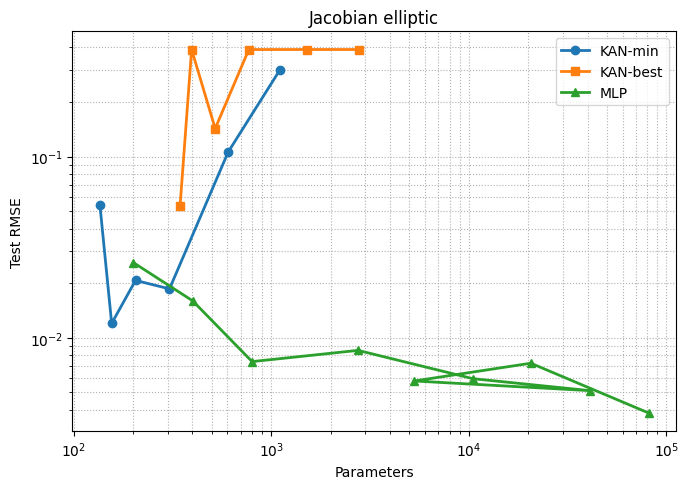


Benchmark: Elliptic integral (1st kind)

--- Training KAN-min for Elliptic integral (1st kind) ---
Generated 1000 valid samples for Elliptic integral (1st kind)
Y range: [0.003, 3.060]
Generated 1000 valid samples for Elliptic integral (1st kind)
Y range: [0.000, 2.729]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.63e-02 | test_loss: 4.17e-02 | reg: 4.75e+00 | : 100%|█| 200/200 [00:35<00:00,  5.56


saving model version 0.1
    params=136, RMSE=2.38e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.67e-02 | test_loss: 4.38e-02 | reg: 8.31e+00 | : 100%|█| 200/200 [00:22<00:00,  8.82


saving model version 0.1
    params=156, RMSE=2.50e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.56e-02 | test_loss: 3.28e-02 | reg: 7.72e+00 | : 100%|█| 200/200 [00:33<00:00,  6.01


saving model version 0.1
    params=206, RMSE=1.88e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.82e-02 | test_loss: 3.66e-02 | reg: 7.72e+00 | : 100%|█| 200/200 [00:45<00:00,  4.44


saving model version 0.1
    params=306, RMSE=2.09e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.01e-02 | test_loss: 4.63e-02 | reg: 4.61e+00 | : 100%|█| 200/200 [00:32<00:00,  6.14


saving model version 0.1
    params=606, RMSE=2.64e-02
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.83e-02 | test_loss: 1.71e-01 | reg: 8.01e+00 | : 100%|█| 200/200 [00:55<00:00,  3.63


saving model version 0.1
    params=1106, RMSE=9.76e-02

--- Training KAN-best for Elliptic integral (1st kind) ---
Generated 1000 valid samples for Elliptic integral (1st kind)
Y range: [0.000, 3.035]
Generated 1000 valid samples for Elliptic integral (1st kind)
Y range: [0.000, 3.450]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.40e-02 | test_loss: 7.25e-02 | reg: 1.19e+01 | : 100%|█| 200/200 [00:48<00:00,  4.12


saving model version 0.1
    params=192, RMSE=4.29e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.89e-01 | reg: 1.47e+00 | : 100%|█| 200/200 [00:23<00:00,  8.60


saving model version 0.1
    params=220, RMSE=5.86e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.57e-01 | test_loss: 3.39e-01 | reg: 1.36e+01 | : 100%|█| 200/200 [01:40<00:00,  1.98


saving model version 0.1
    params=290, RMSE=2.01e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.89e-01 | reg: 2.26e+00 | : 100%|█| 200/200 [00:30<00:00,  6.61


saving model version 0.1
    params=430, RMSE=5.86e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [01:48<00:00,  1.84it/s]


saving model version 0.1
    NaNs detected — skipping
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [01:50<00:00,  1.82it/s]


saving model version 0.1
    NaNs detected — skipping

--- Training MLP for Elliptic integral (1st kind) ---
Generated 1000 valid samples for Elliptic integral (1st kind)
Y range: [0.000, 3.035]
Generated 1000 valid samples for Elliptic integral (1st kind)
Y range: [0.000, 3.450]
  MLP d=2, w=50: params=201, RMSE=8.34e-03
  MLP d=2, w=100: params=401, RMSE=7.86e-03
  MLP d=2, w=200: params=801, RMSE=8.94e-03
  MLP d=3, w=50: params=2751, RMSE=7.68e-03
  MLP d=3, w=100: params=10501, RMSE=8.36e-03
  MLP d=3, w=200: params=41001, RMSE=8.15e-03
  MLP d=4, w=50: params=5301, RMSE=8.07e-03
  MLP d=4, w=100: params=20601, RMSE=7.45e-03
  MLP d=4, w=200: params=81201, RMSE=7.12e-03


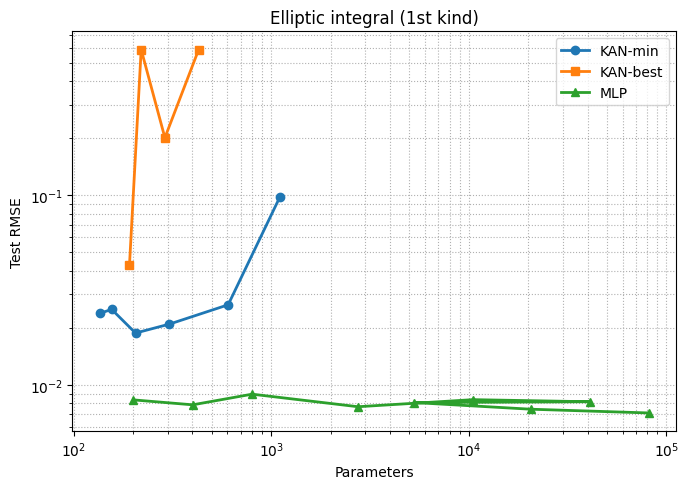


Benchmark: Elliptic integral (2nd kind)

--- Training KAN-min for Elliptic integral (2nd kind) ---
Generated 1000 valid samples for Elliptic integral (2nd kind)
Y range: [0.003, 1.563]
Generated 1000 valid samples for Elliptic integral (2nd kind)
Y range: [0.000, 1.486]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.90e-02 | test_loss: 6.17e-02 | reg: 7.23e+00 | : 100%|█| 200/200 [00:23<00:00,  8.61


saving model version 0.1
    params=136, RMSE=2.45e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.28e-02 | test_loss: 7.53e-02 | reg: 7.51e+00 | : 100%|█| 200/200 [00:24<00:00,  8.20


saving model version 0.1
    params=156, RMSE=2.99e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.08e-02 | test_loss: 4.73e-02 | reg: 7.22e+00 | : 100%|█| 200/200 [00:53<00:00,  3.77


saving model version 0.1
    params=206, RMSE=1.88e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.04e-02 | test_loss: 4.18e-02 | reg: 6.36e+00 | : 100%|█| 200/200 [00:32<00:00,  6.14


saving model version 0.1
    params=306, RMSE=1.66e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.29e-02 | test_loss: 9.12e-02 | reg: 7.31e+00 | : 100%|█| 200/200 [00:31<00:00,  6.45


saving model version 0.1
    params=606, RMSE=3.62e-02
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.92e-02 | test_loss: 1.73e-01 | reg: 7.43e+00 | : 100%|█| 200/200 [00:52<00:00,  3.78


saving model version 0.1
    params=1106, RMSE=6.85e-02

--- Training KAN-best for Elliptic integral (2nd kind) ---
Generated 1000 valid samples for Elliptic integral (2nd kind)
Y range: [0.000, 1.556]
Generated 1000 valid samples for Elliptic integral (2nd kind)
Y range: [0.000, 1.507]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.68e-02 | test_loss: 5.51e-02 | reg: 9.01e+00 | : 100%|█| 200/200 [00:55<00:00,  3.62


saving model version 0.1
    params=164, RMSE=2.23e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.75e-02 | test_loss: 4.84e-02 | reg: 8.43e+00 | : 100%|█| 200/200 [01:19<00:00,  2.52


saving model version 0.1
    params=188, RMSE=1.96e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.61e-01 | test_loss: 2.50e-01 | reg: 9.31e+00 | : 100%|█| 200/200 [01:17<00:00,  2.58


saving model version 0.1
    params=248, RMSE=1.01e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.64e-01 | test_loss: 2.67e-01 | reg: 1.10e+01 | : 100%|█| 200/200 [01:18<00:00,  2.56


saving model version 0.1
    params=368, RMSE=1.08e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.14e-02 | test_loss: 1.07e-01 | reg: 7.29e+00 | : 100%|█| 200/200 [01:11<00:00,  2.81


saving model version 0.1
    params=728, RMSE=4.33e-02
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.00e-02 | test_loss: 1.77e-01 | reg: 7.43e+00 | : 100%|█| 200/200 [01:00<00:00,  3.29


saving model version 0.1
    params=1328, RMSE=7.15e-02

--- Training MLP for Elliptic integral (2nd kind) ---
Generated 1000 valid samples for Elliptic integral (2nd kind)
Y range: [0.000, 1.556]
Generated 1000 valid samples for Elliptic integral (2nd kind)
Y range: [0.000, 1.507]
  MLP d=2, w=50: params=201, RMSE=2.17e-03
  MLP d=2, w=100: params=401, RMSE=1.50e-03
  MLP d=2, w=200: params=801, RMSE=1.23e-03
  MLP d=3, w=50: params=2751, RMSE=1.50e-03
  MLP d=3, w=100: params=10501, RMSE=1.07e-03
  MLP d=3, w=200: params=41001, RMSE=8.48e-04
  MLP d=4, w=50: params=5301, RMSE=9.17e-04
  MLP d=4, w=100: params=20601, RMSE=1.09e-03
  MLP d=4, w=200: params=81201, RMSE=1.34e-03


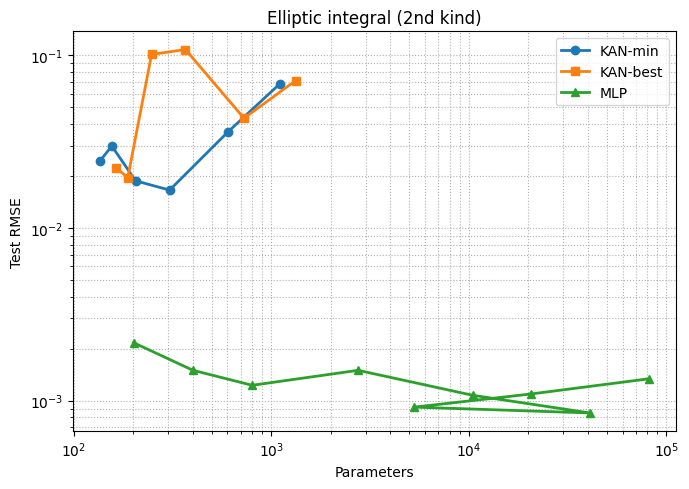


Benchmark: Bessel J

--- Training KAN-min for Bessel J ---
Generated 1000 valid samples for Bessel J
Y range: [-0.393, 0.829]
Generated 1000 valid samples for Bessel J
Y range: [-0.398, 0.960]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.75e-02 | test_loss: 8.79e-02 | reg: 9.52e+00 | : 100%|█| 200/200 [00:57<00:00,  3.46


saving model version 0.1
    params=136, RMSE=2.12e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.66e-02 | test_loss: 9.35e-02 | reg: 9.32e+00 | : 100%|█| 200/200 [00:58<00:00,  3.44


saving model version 0.1
    params=156, RMSE=2.26e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.01e-02 | test_loss: 1.23e-01 | reg: 9.47e+00 | : 100%|█| 200/200 [00:40<00:00,  4.91


saving model version 0.1
    params=206, RMSE=2.98e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.08e-02 | test_loss: 1.41e-01 | reg: 9.28e+00 | : 100%|█| 200/200 [00:59<00:00,  3.38


saving model version 0.1
    params=306, RMSE=3.40e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.23e-01 | test_loss: 6.03e-01 | reg: 1.01e+01 | : 100%|█| 200/200 [00:53<00:00,  3.72


saving model version 0.1
    params=606, RMSE=1.46e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.23e-01 | test_loss: 4.05e-01 | reg: 5.44e+00 | : 100%|█| 200/200 [00:59<00:00,  3.37


saving model version 0.1
    params=1106, RMSE=9.77e-02

--- Training KAN-best for Bessel J ---
Generated 1000 valid samples for Bessel J
Y range: [-0.390, 0.957]
Generated 1000 valid samples for Bessel J
Y range: [-0.401, 0.915]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.58e-01 | reg: 1.13e+00 | : 100%|█| 200/200 [00:45<00:00,  4.36


saving model version 0.1
    params=248, RMSE=2.36e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.64e-01 | test_loss: 3.68e-01 | reg: 1.49e+01 | : 100%|█| 200/200 [01:53<00:00,  1.77


saving model version 0.1
    params=284, RMSE=9.07e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.78e-01 | test_loss: 4.76e-01 | reg: 1.39e+01 | : 100%|█| 200/200 [01:52<00:00,  1.77


saving model version 0.1
    params=374, RMSE=1.17e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.48e-01 | test_loss: 5.54e-01 | reg: 1.47e+01 | : 100%|█| 200/200 [01:51<00:00,  1.79


saving model version 0.1
    params=554, RMSE=1.37e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.58e-01 | reg: 3.38e+00 | : 100%|█| 200/200 [01:23<00:00,  2.40


saving model version 0.1
    params=1094, RMSE=2.36e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.96e-01 | test_loss: 7.21e+00 | reg: 1.07e+01 | : 100%|█| 200/200 [01:44<00:00,  1.91


saving model version 0.1
    params=1994, RMSE=1.78e+00

--- Training MLP for Bessel J ---
Generated 1000 valid samples for Bessel J
Y range: [-0.390, 0.957]
Generated 1000 valid samples for Bessel J
Y range: [-0.401, 0.915]
  MLP d=2, w=50: params=201, RMSE=7.33e-03
  MLP d=2, w=100: params=401, RMSE=5.61e-03
  MLP d=2, w=200: params=801, RMSE=4.02e-03
  MLP d=3, w=50: params=2751, RMSE=5.76e-03
  MLP d=3, w=100: params=10501, RMSE=5.82e-03
  MLP d=3, w=200: params=41001, RMSE=4.21e-03
  MLP d=4, w=50: params=5301, RMSE=3.28e-03
  MLP d=4, w=100: params=20601, RMSE=3.73e-03
  MLP d=4, w=200: params=81201, RMSE=3.83e-03


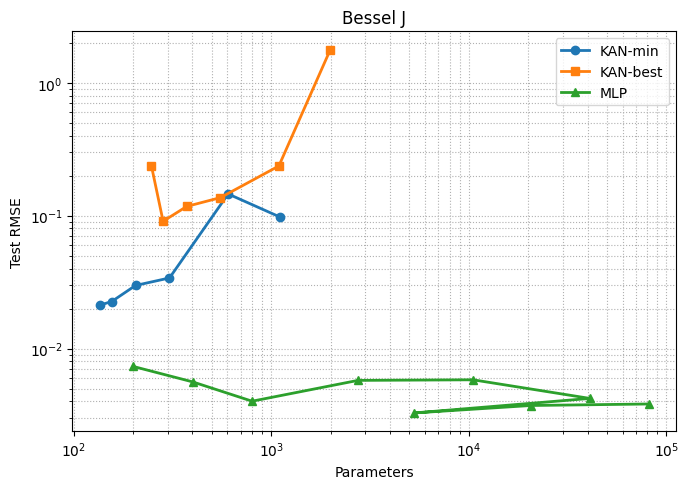


Benchmark: Bessel Y

--- Training KAN-min for Bessel Y ---
Generated 1000 valid samples for Bessel Y
Y range: [-21422584.000, 0.517]
Generated 1000 valid samples for Bessel Y
Y range: [-680450.375, 0.508]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.78e-02 | test_loss: 1.14e-01 | reg: 5.66e+00 | : 100%|█| 200/200 [00:21<00:00,  9.18


saving model version 0.1
    params=192, RMSE=8.72e+04
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.07e-01 | test_loss: 1.00e-01 | reg: 5.58e+00 | : 100%|█| 200/200 [00:29<00:00,  6.90


saving model version 0.1
    params=220, RMSE=7.64e+04
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.48e-02 | test_loss: 7.81e-02 | reg: 5.34e+00 | : 100%|█| 200/200 [00:32<00:00,  6.12


saving model version 0.1
    params=290, RMSE=5.95e+04
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.93e-02 | test_loss: 4.63e-02 | reg: 5.09e+00 | : 100%|█| 200/200 [00:26<00:00,  7.53


saving model version 0.1
    params=430, RMSE=3.53e+04
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.20e-02 | test_loss: 8.43e-01 | reg: 5.07e+00 | : 100%|█| 200/200 [00:17<00:00, 11.40


saving model version 0.1
    params=850, RMSE=6.43e+05
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e-02 | test_loss: 4.81e-01 | reg: 5.04e+00 | : 100%|█| 200/200 [00:59<00:00,  3.38


saving model version 0.1
    params=1550, RMSE=3.67e+05

--- Training KAN-best for Bessel Y ---
Generated 1000 valid samples for Bessel Y
Y range: [-5867855.000, 0.517]
Generated 1000 valid samples for Bessel Y
Y range: [-1638955.000, 0.504]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 2.70e-01 | reg: 4.18e-01 | : 100%|█| 200/200 [00:34<00:00,  5.82


saving model version 0.1
    params=220, RMSE=5.32e+04
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 2.69e-01 | reg: 3.30e-01 | : 100%|█| 200/200 [00:40<00:00,  5.00


saving model version 0.1
    params=252, RMSE=5.29e+04
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 2.69e-01 | reg: 2.30e-01 | : 100%|█| 200/200 [00:50<00:00,  3.93


saving model version 0.1
    params=332, RMSE=5.29e+04
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [01:21<00:00,  2.44it/s]


saving model version 0.1
    NaNs detected — skipping
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.46e-02 | test_loss: 3.72e+00 | reg: 1.03e+01 | : 100%|█| 200/200 [01:18<00:00,  2.56


saving model version 0.1
    params=972, RMSE=7.32e+05
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 2.68e-01 | reg: 1.26e+00 | : 100%|█| 200/200 [00:49<00:00,  4.00


saving model version 0.1
    params=1772, RMSE=5.28e+04

--- Training MLP for Bessel Y ---
Generated 1000 valid samples for Bessel Y
Y range: [-5867855.000, 0.517]
Generated 1000 valid samples for Bessel Y
Y range: [-1638955.000, 0.504]
  MLP d=2, w=50: params=201, RMSE=2.33e+04
  MLP d=2, w=100: params=401, RMSE=1.99e+04
  MLP d=2, w=200: params=801, RMSE=1.17e+04
  MLP d=3, w=50: params=2751, RMSE=1.29e+04
  MLP d=3, w=100: params=10501, RMSE=6.76e+03
  MLP d=3, w=200: params=41001, RMSE=1.23e+04
  MLP d=4, w=100: params=20601, RMSE=1.43e+04
  MLP d=4, w=200: params=81201, RMSE=5.24e+04


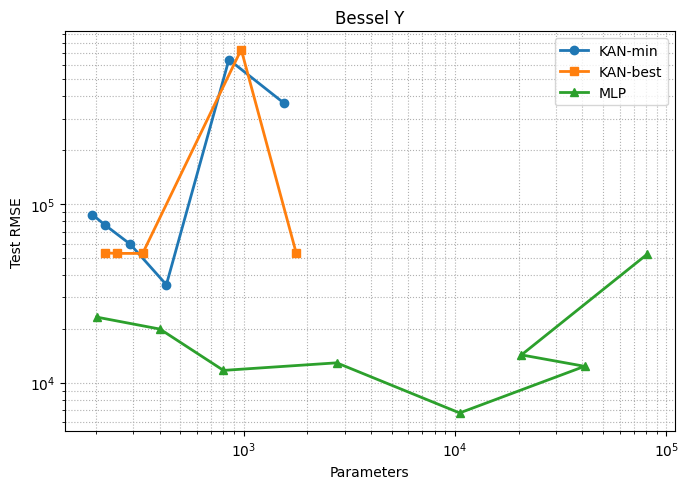


Benchmark: Modified Bessel K

--- Training KAN-min for Modified Bessel K ---
Generated 1000 valid samples for Modified Bessel K
Y range: [0.003, 33607872.000]
Generated 1000 valid samples for Modified Bessel K
Y range: [0.003, 1066572.375]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 6.03e-02 | reg: 2.40e-01 | : 100%|█| 200/200 [00:24<00:00,  8.31


saving model version 0.1
    params=80, RMSE=7.22e+04
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 6.59e-02 | reg: 2.57e-02 | : 100%|█| 200/200 [00:23<00:00,  8.62


saving model version 0.1
    params=92, RMSE=7.88e+04
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.42e-02 | test_loss: 1.09e-01 | reg: 6.96e+00 | : 100%|█| 200/200 [00:54<00:00,  3.67


saving model version 0.1
    params=122, RMSE=1.30e+05
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.35e-02 | test_loss: 1.28e-01 | reg: 5.51e+00 | : 100%|█| 200/200 [00:54<00:00,  3.66


saving model version 0.1
    params=182, RMSE=1.53e+05
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.61e-02 | test_loss: 5.04e-01 | reg: 5.43e+00 | : 100%|█| 200/200 [00:53<00:00,  3.77


saving model version 0.1
    params=362, RMSE=6.03e+05
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.92e-02 | test_loss: 9.54e+00 | reg: 6.60e+00 | : 100%|█| 200/200 [00:50<00:00,  3.95


saving model version 0.1
    params=662, RMSE=1.14e+07

--- Training KAN-best for Modified Bessel K ---
Generated 1000 valid samples for Modified Bessel K
Y range: [0.003, 9202036.000]
Generated 1000 valid samples for Modified Bessel K
Y range: [0.004, 2567324.250]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 2.68e-01 | reg: 1.01e-01 | : 100%|█| 200/200 [00:23<00:00,  8.65


saving model version 0.1
    params=136, RMSE=8.27e+04
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 2.68e-01 | reg: 1.85e-01 | : 100%|█| 200/200 [00:21<00:00,  9.41


saving model version 0.1
    params=156, RMSE=8.26e+04
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.88e-02 | test_loss: 6.63e-01 | reg: 7.03e+00 | : 100%|█| 200/200 [00:26<00:00,  7.43


saving model version 0.1
    params=206, RMSE=2.04e+05
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 2.69e-01 | reg: 1.14e-02 | : 100%|█| 200/200 [00:24<00:00,  8.08


saving model version 0.1
    params=306, RMSE=8.29e+04
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.92e-02 | test_loss: 3.14e+00 | reg: 5.46e+00 | : 100%|█| 200/200 [00:51<00:00,  3.90


saving model version 0.1
    params=606, RMSE=9.68e+05
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.68e-02 | test_loss: 2.51e+00 | reg: 6.44e+00 | : 100%|█| 200/200 [00:44<00:00,  4.46


saving model version 0.1
    params=1106, RMSE=7.74e+05

--- Training MLP for Modified Bessel K ---
Generated 1000 valid samples for Modified Bessel K
Y range: [0.003, 9202036.000]
Generated 1000 valid samples for Modified Bessel K
Y range: [0.004, 2567324.250]
  MLP d=2, w=50: params=201, RMSE=8.21e+04
  MLP d=2, w=100: params=401, RMSE=8.21e+04
  MLP d=2, w=200: params=801, RMSE=1.90e+04
  MLP d=3, w=100: params=10501, RMSE=2.17e+03
  MLP d=4, w=50: params=5301, RMSE=8.21e+04
  MLP d=4, w=100: params=20601, RMSE=8.21e+04
  MLP d=4, w=200: params=81201, RMSE=1.54e+04


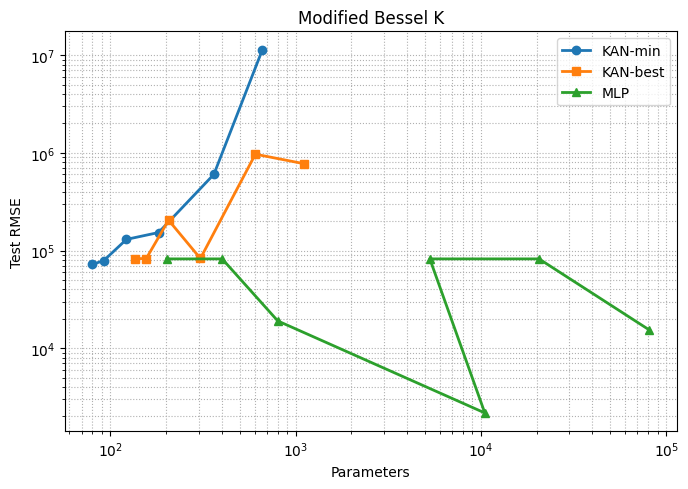


Benchmark: Modified Bessel I

--- Training KAN-min for Modified Bessel I ---
Generated 1000 valid samples for Modified Bessel I
Y range: [0.000, 29.270]
Generated 1000 valid samples for Modified Bessel I
Y range: [0.000, 28.622]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.10e-02 | test_loss: 5.42e-02 | reg: 1.09e+01 | : 100%|█| 200/200 [01:43<00:00,  1.93


saving model version 0.1
    params=542, RMSE=2.83e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.90e-02 | test_loss: 7.73e-02 | reg: 1.05e+01 | : 100%|█| 200/200 [01:33<00:00,  2.14


saving model version 0.1
    params=620, RMSE=4.03e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.16e-01 | test_loss: 3.56e-01 | reg: 1.61e+01 | : 100%|█| 200/200 [01:41<00:00,  1.97


saving model version 0.1
    params=815, RMSE=1.86e+00
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.53e-02 | test_loss: 6.52e-01 | reg: 2.05e+01 | : 100%|█| 200/200 [01:41<00:00,  1.97


saving model version 0.1
    params=1205, RMSE=3.40e+00
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.06e-01 | test_loss: 5.84e-01 | reg: 1.99e+01 | : 100%|█| 200/200 [01:39<00:00,  2.01


saving model version 0.1
    params=2375, RMSE=3.05e+00
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.56e-01 | test_loss: 9.31e-01 | reg: 1.32e+01 | : 100%|█| 200/200 [01:42<00:00,  1.95


saving model version 0.1
    params=4325, RMSE=4.85e+00

--- Training KAN-best for Modified Bessel I ---
Generated 1000 valid samples for Modified Bessel I
Y range: [0.000, 29.484]
Generated 1000 valid samples for Modified Bessel I
Y range: [0.000, 26.700]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.80e-02 | test_loss: 3.86e-02 | reg: 9.25e+00 | : 100%|█| 200/200 [00:55<00:00,  3.60


saving model version 0.1
    params=542, RMSE=1.93e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.91e-02 | test_loss: 6.28e-02 | reg: 1.06e+01 | : 100%|█| 200/200 [01:42<00:00,  1.96


saving model version 0.1
    params=620, RMSE=3.14e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.56e-02 | test_loss: 1.70e-01 | reg: 1.30e+01 | : 100%|█| 200/200 [01:43<00:00,  1.93


saving model version 0.1
    params=815, RMSE=8.47e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.22e-02 | test_loss: 3.61e-01 | reg: 1.97e+01 | : 100%|█| 200/200 [01:40<00:00,  1.98


saving model version 0.1
    params=1205, RMSE=1.80e+00
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 6.15e-01 | reg: 1.91e+01 | : 100%|█| 200/200 [01:41<00:00,  1.96


saving model version 0.1
    params=2375, RMSE=3.07e+00
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.87e-01 | test_loss: 9.47e-01 | reg: 1.15e+01 | : 100%|█| 200/200 [01:43<00:00,  1.93


saving model version 0.1
    params=4325, RMSE=4.73e+00

--- Training MLP for Modified Bessel I ---
Generated 1000 valid samples for Modified Bessel I
Y range: [0.000, 29.484]
Generated 1000 valid samples for Modified Bessel I
Y range: [0.000, 26.700]
  MLP d=2, w=100: params=401, RMSE=5.17e-02
  MLP d=2, w=200: params=801, RMSE=4.99e-02
  MLP d=3, w=50: params=2751, RMSE=7.40e-02
  MLP d=3, w=100: params=10501, RMSE=2.29e-02
  MLP d=3, w=200: params=41001, RMSE=1.61e-02
  MLP d=4, w=50: params=5301, RMSE=2.90e-02
  MLP d=4, w=100: params=20601, RMSE=1.98e-02
  MLP d=4, w=200: params=81201, RMSE=1.38e-02


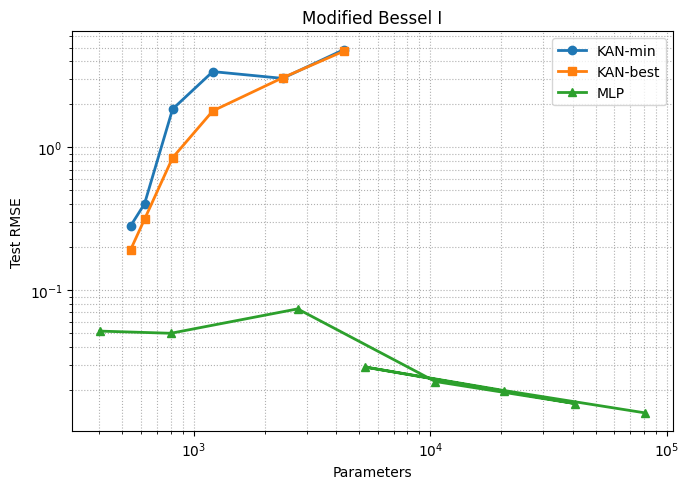


Benchmark: Legendre m=0

--- Training KAN-min for Legendre m=0 ---
Generated 1000 valid samples for Legendre m=0
Y range: [-1.495, 1.001]
Generated 1000 valid samples for Legendre m=0
Y range: [-0.901, 0.999]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.78e-01 | test_loss: 3.49e-01 | reg: 1.01e+01 | : 100%|█| 200/200 [00:54<00:00,  3.64


saving model version 0.1
    params=136, RMSE=1.63e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e-01 | test_loss: 1.65e-01 | reg: 9.98e+00 | : 100%|█| 200/200 [00:49<00:00,  4.07


saving model version 0.1
    params=156, RMSE=7.69e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.18e-01 | test_loss: 9.61e-02 | reg: 9.28e+00 | : 100%|█| 200/200 [00:53<00:00,  3.72


saving model version 0.1
    params=206, RMSE=4.49e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.22e-01 | test_loss: 1.42e-01 | reg: 9.96e+00 | : 100%|█| 200/200 [00:54<00:00,  3.67


saving model version 0.1
    params=306, RMSE=6.64e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.96e-01 | test_loss: 7.22e-01 | reg: 9.81e+00 | : 100%|█| 200/200 [00:52<00:00,  3.78


saving model version 0.1
    params=606, RMSE=3.37e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.23e-01 | test_loss: 8.12e-01 | reg: 9.90e+00 | : 100%|█| 200/200 [00:54<00:00,  3.67


saving model version 0.1
    params=1106, RMSE=3.79e-01

--- Training KAN-best for Legendre m=0 ---
Generated 1000 valid samples for Legendre m=0
Y range: [-1.888, 1.000]
Generated 1000 valid samples for Legendre m=0
Y range: [-1.539, 1.000]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.23e-01 | test_loss: 3.36e-01 | reg: 1.15e+01 | : 100%|█| 200/200 [00:53<00:00,  3.71


saving model version 0.1
    params=136, RMSE=1.57e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.94e-01 | test_loss: 2.00e-01 | reg: 9.75e+00 | : 100%|█| 200/200 [00:46<00:00,  4.26


saving model version 0.1
    params=156, RMSE=9.33e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.36e-01 | test_loss: 2.58e-01 | reg: 5.42e+00 | : 100%|█| 200/200 [00:13<00:00, 15.24


saving model version 0.1
    params=206, RMSE=1.20e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.09e-01 | test_loss: 4.13e-01 | reg: 9.92e+00 | : 100%|█| 200/200 [00:52<00:00,  3.82


saving model version 0.1
    params=306, RMSE=1.93e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.21e-01 | test_loss: 8.48e-01 | reg: 1.03e+01 | : 100%|█| 200/200 [00:53<00:00,  3.76


saving model version 0.1
    params=606, RMSE=3.96e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.18e-02 | test_loss: 5.42e-01 | reg: 9.13e+00 | : 100%|█| 200/200 [00:54<00:00,  3.67


saving model version 0.1
    params=1106, RMSE=2.53e-01

--- Training MLP for Legendre m=0 ---
Generated 1000 valid samples for Legendre m=0
Y range: [-1.888, 1.000]
Generated 1000 valid samples for Legendre m=0
Y range: [-1.539, 1.000]
  MLP d=2, w=50: params=201, RMSE=1.70e-01
  MLP d=2, w=100: params=401, RMSE=9.46e-02
  MLP d=3, w=50: params=2751, RMSE=1.02e-01
  MLP d=3, w=100: params=10501, RMSE=9.46e-02
  MLP d=3, w=200: params=41001, RMSE=9.16e-02
  MLP d=4, w=50: params=5301, RMSE=7.64e-02
  MLP d=4, w=100: params=20601, RMSE=7.81e-02
  MLP d=4, w=200: params=81201, RMSE=8.93e-02


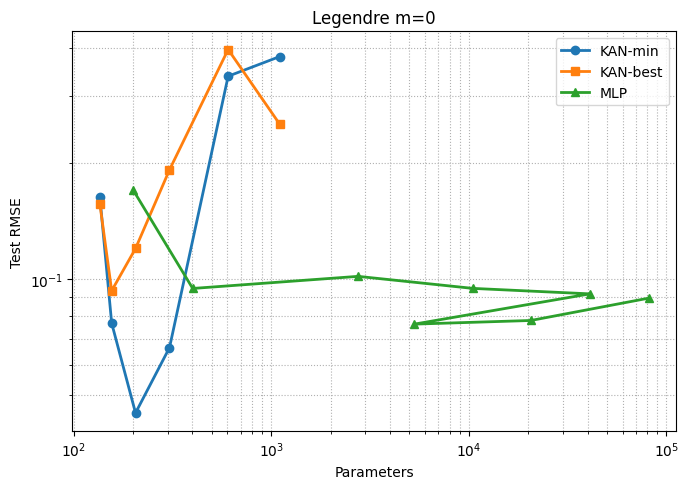


Benchmark: Legendre m=1

--- Training KAN-min for Legendre m=1 ---
Generated 1000 valid samples for Legendre m=1
Y range: [-11.928, 3.258]
Generated 1000 valid samples for Legendre m=1
Y range: [-4.960, 3.195]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.10e-01 | test_loss: 2.88e-01 | reg: 1.60e+01 | : 100%|█| 200/200 [00:27<00:00,  7.27


saving model version 0.1
    params=248, RMSE=3.72e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.29e-01 | test_loss: 2.16e-01 | reg: 1.21e+01 | : 100%|█| 200/200 [00:42<00:00,  4.74


saving model version 0.1
    params=284, RMSE=2.79e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.18e-01 | test_loss: 1.51e-01 | reg: 1.08e+01 | : 100%|█| 200/200 [00:49<00:00,  4.04


saving model version 0.1
    params=374, RMSE=1.95e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 1.88e-01 | reg: 8.02e+00 | : 100%|█| 200/200 [00:22<00:00,  8.72


saving model version 0.1
    params=554, RMSE=2.43e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e-01 | test_loss: 8.52e-01 | reg: 1.40e+01 | : 100%|█| 200/200 [00:55<00:00,  3.62


saving model version 0.1
    params=1094, RMSE=1.10e+00
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.70e-02 | test_loss: 8.86e-01 | reg: 1.20e+01 | : 100%|█| 200/200 [00:54<00:00,  3.68


saving model version 0.1
    params=1994, RMSE=1.15e+00

--- Training KAN-best for Legendre m=1 ---
Generated 1000 valid samples for Legendre m=1
Y range: [-7.241, 5.974]
Generated 1000 valid samples for Legendre m=1
Y range: [-17.645, 4.170]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.94e-01 | test_loss: 3.60e-01 | reg: 1.67e+01 | : 100%|█| 200/200 [00:54<00:00,  3.69


saving model version 0.1
    params=248, RMSE=4.48e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.67e-01 | test_loss: 4.28e-01 | reg: 1.20e+01 | : 100%|█| 200/200 [00:49<00:00,  4.06


saving model version 0.1
    params=284, RMSE=5.31e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.28e-01 | test_loss: 3.72e-01 | reg: 1.30e+01 | : 100%|█| 200/200 [00:52<00:00,  3.78


saving model version 0.1
    params=374, RMSE=4.62e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-01 | test_loss: 5.51e-01 | reg: 1.03e+01 | : 100%|█| 200/200 [00:54<00:00,  3.65


saving model version 0.1
    params=554, RMSE=6.84e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.80e-02 | test_loss: 6.28e-01 | reg: 1.41e+01 | : 100%|█| 200/200 [00:55<00:00,  3.63


saving model version 0.1
    params=1094, RMSE=7.80e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.44e-02 | test_loss: 9.28e-01 | reg: 1.41e+01 | : 100%|█| 200/200 [00:54<00:00,  3.67


saving model version 0.1
    params=1994, RMSE=1.15e+00

--- Training MLP for Legendre m=1 ---
Generated 1000 valid samples for Legendre m=1
Y range: [-7.241, 5.974]
Generated 1000 valid samples for Legendre m=1
Y range: [-17.645, 4.170]
  MLP d=2, w=50: params=201, RMSE=7.95e-01
  MLP d=2, w=100: params=401, RMSE=5.84e-01
  MLP d=2, w=200: params=801, RMSE=7.59e-01
  MLP d=3, w=50: params=2751, RMSE=5.64e-01
  MLP d=3, w=100: params=10501, RMSE=5.05e-01
  MLP d=4, w=50: params=5301, RMSE=4.94e-01
  MLP d=4, w=100: params=20601, RMSE=5.73e-01
  MLP d=4, w=200: params=81201, RMSE=5.42e-01


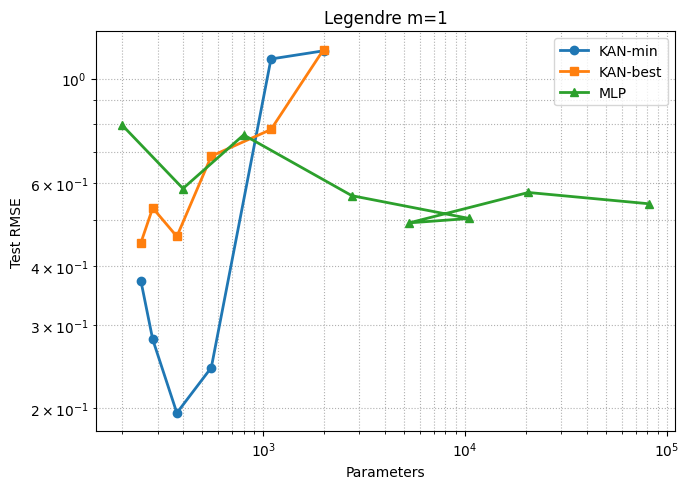


Benchmark: Legendre m=2

--- Training KAN-min for Legendre m=2 ---
Generated 1000 valid samples for Legendre m=2
Y range: [-792.482, 21.792]
Generated 1000 valid samples for Legendre m=2
Y range: [-87.607, 27.026]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.64e-01 | test_loss: 2.22e-01 | reg: 8.63e+00 | : 100%|█| 200/200 [00:22<00:00,  8.96


saving model version 0.1
    params=136, RMSE=6.24e+00
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.95e-01 | test_loss: 2.30e-01 | reg: 8.81e+00 | : 100%|█| 200/200 [00:16<00:00, 11.79


saving model version 0.1
    params=156, RMSE=6.48e+00
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.25e-01 | test_loss: 3.64e-01 | reg: 6.40e+00 | : 100%|█| 200/200 [00:25<00:00,  7.83


saving model version 0.1
    params=206, RMSE=1.02e+01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 2.52e-01 | reg: 1.04e-01 | : 100%|█| 200/200 [00:22<00:00,  9.05


saving model version 0.1
    params=306, RMSE=7.08e+00
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.30e-01 | test_loss: 4.92e+00 | reg: 5.44e+00 | : 100%|█| 200/200 [00:58<00:00,  3.41


saving model version 0.1
    params=606, RMSE=1.38e+02
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.14e-01 | test_loss: 3.92e+00 | reg: 6.12e+00 | : 100%|█| 200/200 [00:56<00:00,  3.56


saving model version 0.1
    params=1106, RMSE=1.10e+02

--- Training KAN-best for Legendre m=2 ---
Generated 1000 valid samples for Legendre m=2
Y range: [-228.975, 94.393]
Generated 1000 valid samples for Legendre m=2
Y range: [-1130.785, 41.829]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.41e-01 | test_loss: 2.96e+00 | reg: 7.11e+00 | : 100%|█| 200/200 [00:40<00:00,  4.89


saving model version 0.1
    params=290, RMSE=3.36e+01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 3.18e+00 | reg: 2.08e-01 | : 100%|█| 200/200 [00:23<00:00,  8.36


saving model version 0.1
    params=332, RMSE=3.62e+01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.01e-01 | test_loss: 3.51e+00 | reg: 1.02e+01 | : 100%|█| 200/200 [01:18<00:00,  2.54


saving model version 0.1
    params=437, RMSE=4.00e+01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.15e-01 | test_loss: 4.35e+00 | reg: 1.09e+01 | : 100%|█| 200/200 [01:19<00:00,  2.50


saving model version 0.1
    params=647, RMSE=4.95e+01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.14e-01 | test_loss: 3.37e+00 | reg: 9.15e+00 | : 100%|█| 200/200 [01:20<00:00,  2.47


saving model version 0.1
    params=1277, RMSE=3.84e+01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.15e-01 | test_loss: 3.19e+00 | reg: 8.59e+00 | : 100%|█| 200/200 [01:22<00:00,  2.42


saving model version 0.1
    params=2327, RMSE=3.63e+01

--- Training MLP for Legendre m=2 ---
Generated 1000 valid samples for Legendre m=2
Y range: [-228.975, 94.393]
Generated 1000 valid samples for Legendre m=2
Y range: [-1130.785, 41.829]
  MLP d=2, w=100: params=401, RMSE=3.16e+01
  MLP d=2, w=200: params=801, RMSE=3.24e+01
  MLP d=3, w=50: params=2751, RMSE=3.11e+01
  MLP d=3, w=100: params=10501, RMSE=3.19e+01
  MLP d=3, w=200: params=41001, RMSE=3.18e+01
  MLP d=4, w=50: params=5301, RMSE=3.29e+01
  MLP d=4, w=100: params=20601, RMSE=3.12e+01
  MLP d=4, w=200: params=81201, RMSE=3.15e+01


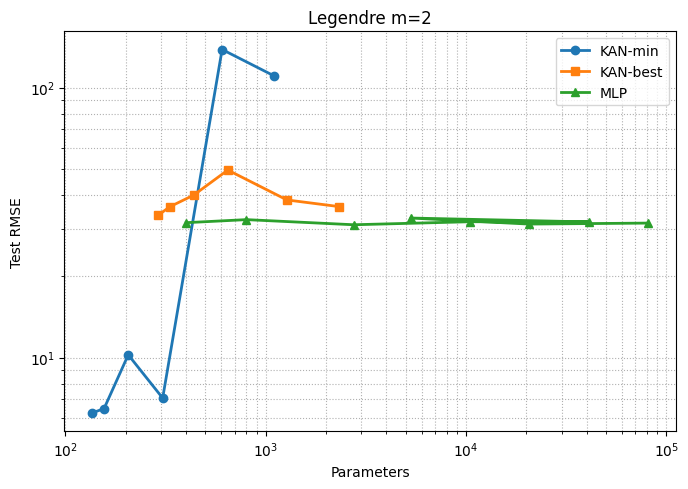

/tmp/ipykernel_19/3274818750.py:90: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  func=lambda x: scipy.special.sph_harm(0, 1, x[:,0], x[:,1]).real,



Benchmark: Sph harm (0,1)

--- Training KAN-min for Sph harm (0,1) ---
Generated 1000 valid samples for Sph harm (0,1)
Y range: [-0.489, 0.489]
Generated 1000 valid samples for Sph harm (0,1)
Y range: [-0.489, 0.489]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.49e-02 | test_loss: 1.44e-02 | reg: 5.43e+00 | : 100%|█| 200/200 [00:21<00:00,  9.44


saving model version 0.1
    params=80, RMSE=5.01e-03
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.94e-03 | test_loss: 6.81e-03 | reg: 5.37e+00 | : 100%|█| 200/200 [00:34<00:00,  5.73


saving model version 0.1
    params=92, RMSE=2.37e-03
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.94e-03 | test_loss: 9.01e-03 | reg: 5.38e+00 | : 100%|█| 200/200 [00:19<00:00, 10.15


saving model version 0.1
    params=122, RMSE=3.13e-03
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.33e-02 | test_loss: 6.34e-02 | reg: 5.42e+00 | : 100%|█| 200/200 [00:37<00:00,  5.36


saving model version 0.1
    params=182, RMSE=2.20e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.36e-03 | test_loss: 1.14e-02 | reg: 5.36e+00 | : 100%|█| 200/200 [00:32<00:00,  6.09


saving model version 0.1
    params=362, RMSE=3.96e-03
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.21e-02 | test_loss: 3.57e-02 | reg: 5.48e+00 | : 100%|█| 200/200 [00:23<00:00,  8.59


saving model version 0.1
    params=662, RMSE=1.24e-02

--- Training KAN-best for Sph harm (0,1) ---
Generated 1000 valid samples for Sph harm (0,1)
Y range: [-0.489, 0.489]
Generated 1000 valid samples for Sph harm (0,1)
Y range: [-0.489, 0.489]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.52e-02 | test_loss: 1.47e-02 | reg: 5.42e+00 | : 100%|█| 200/200 [00:20<00:00,  9.61


saving model version 0.1
    params=80, RMSE=4.95e-03
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.75e-03 | test_loss: 5.84e-03 | reg: 5.37e+00 | : 100%|█| 200/200 [00:25<00:00,  7.74


saving model version 0.1
    params=92, RMSE=1.96e-03
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.41e-03 | test_loss: 8.24e-03 | reg: 5.39e+00 | : 100%|█| 200/200 [00:19<00:00, 10.03


saving model version 0.1
    params=122, RMSE=2.77e-03
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.34e-02 | test_loss: 5.88e-02 | reg: 5.41e+00 | : 100%|█| 200/200 [00:51<00:00,  3.86


saving model version 0.1
    params=182, RMSE=1.98e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.01e-03 | test_loss: 8.47e-03 | reg: 5.36e+00 | : 100%|█| 200/200 [00:30<00:00,  6.63


saving model version 0.1
    params=362, RMSE=2.85e-03
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.85e-02 | test_loss: 9.99e-02 | reg: 5.53e+00 | : 100%|█| 200/200 [00:24<00:00,  8.11


saving model version 0.1
    params=662, RMSE=3.36e-02

--- Training MLP for Sph harm (0,1) ---
Generated 1000 valid samples for Sph harm (0,1)
Y range: [-0.489, 0.489]
Generated 1000 valid samples for Sph harm (0,1)
Y range: [-0.489, 0.489]
  MLP d=2, w=50: params=201, RMSE=8.30e-03
  MLP d=2, w=100: params=401, RMSE=5.18e-03
  MLP d=2, w=200: params=801, RMSE=4.13e-03
  MLP d=3, w=50: params=2751, RMSE=2.70e-03
  MLP d=3, w=100: params=10501, RMSE=2.50e-03
  MLP d=3, w=200: params=41001, RMSE=1.39e-03
  MLP d=4, w=50: params=5301, RMSE=1.73e-03
  MLP d=4, w=100: params=20601, RMSE=1.42e-03
  MLP d=4, w=200: params=81201, RMSE=1.36e-03


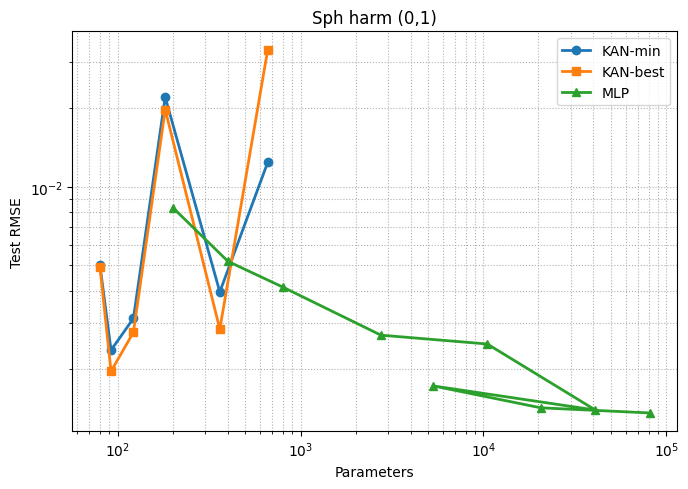

/tmp/ipykernel_19/3274818750.py:98: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  func=lambda x: scipy.special.sph_harm(1, 1, x[:,0], x[:,1]).real,



Benchmark: Sph harm (1,1)

--- Training KAN-min for Sph harm (1,1) ---
Generated 1000 valid samples for Sph harm (1,1)
Y range: [-0.345, 0.345]
Generated 1000 valid samples for Sph harm (1,1)
Y range: [-0.345, 0.345]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.84e-02 | test_loss: 4.88e-02 | reg: 9.33e+00 | : 100%|█| 200/200 [00:46<00:00,  4.32


saving model version 0.1
    params=136, RMSE=8.51e-03
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.13e-02 | test_loss: 4.94e-02 | reg: 1.02e+01 | : 100%|█| 200/200 [00:33<00:00,  5.89


saving model version 0.1
    params=156, RMSE=8.61e-03
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.10e-02 | test_loss: 6.39e-02 | reg: 8.79e+00 | : 100%|█| 200/200 [00:53<00:00,  3.77


saving model version 0.1
    params=206, RMSE=1.11e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e-01 | test_loss: 2.05e-01 | reg: 1.03e+01 | : 100%|█| 200/200 [00:54<00:00,  3.68


saving model version 0.1
    params=306, RMSE=3.57e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.86e-02 | test_loss: 1.75e-01 | reg: 8.04e+00 | : 100%|█| 200/200 [00:53<00:00,  3.71


saving model version 0.1
    params=606, RMSE=3.05e-02
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.99e-02 | test_loss: 3.01e-01 | reg: 8.30e+00 | : 100%|█| 200/200 [00:54<00:00,  3.69


saving model version 0.1
    params=1106, RMSE=5.25e-02

--- Training KAN-best for Sph harm (1,1) ---
Generated 1000 valid samples for Sph harm (1,1)
Y range: [-0.345, 0.345]
Generated 1000 valid samples for Sph harm (1,1)
Y range: [-0.345, 0.345]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.36e-02 | test_loss: 5.73e-02 | reg: 1.25e+01 | : 100%|█| 200/200 [00:55<00:00,  3.58


saving model version 0.1
    params=290, RMSE=9.96e-03
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.56e-02 | test_loss: 8.19e-02 | reg: 1.37e+01 | : 100%|█| 200/200 [01:09<00:00,  2.89


saving model version 0.1
    params=332, RMSE=1.43e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 2.17e-01 | reg: 1.01e+01 | : 100%|█| 200/200 [01:18<00:00,  2.55


saving model version 0.1
    params=437, RMSE=3.78e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.16e-01 | test_loss: 2.82e-01 | reg: 1.55e+01 | : 100%|█| 200/200 [01:18<00:00,  2.55


saving model version 0.1
    params=647, RMSE=4.90e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.36e-01 | test_loss: 8.83e-01 | reg: 1.49e+01 | : 100%|█| 200/200 [01:17<00:00,  2.59


saving model version 0.1
    params=1277, RMSE=1.54e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.63e-01 | test_loss: 7.52e-01 | reg: 1.25e+01 | : 100%|█| 200/200 [01:16<00:00,  2.62


saving model version 0.1
    params=2327, RMSE=1.31e-01

--- Training MLP for Sph harm (1,1) ---
Generated 1000 valid samples for Sph harm (1,1)
Y range: [-0.345, 0.345]
Generated 1000 valid samples for Sph harm (1,1)
Y range: [-0.345, 0.345]
  MLP d=2, w=50: params=201, RMSE=3.09e-02
  MLP d=2, w=200: params=801, RMSE=1.16e-02
  MLP d=3, w=50: params=2751, RMSE=6.68e-03
  MLP d=3, w=100: params=10501, RMSE=6.21e-03
  MLP d=3, w=200: params=41001, RMSE=5.85e-03
  MLP d=4, w=50: params=5301, RMSE=2.95e-03
  MLP d=4, w=100: params=20601, RMSE=6.12e-03
  MLP d=4, w=200: params=81201, RMSE=4.81e-03


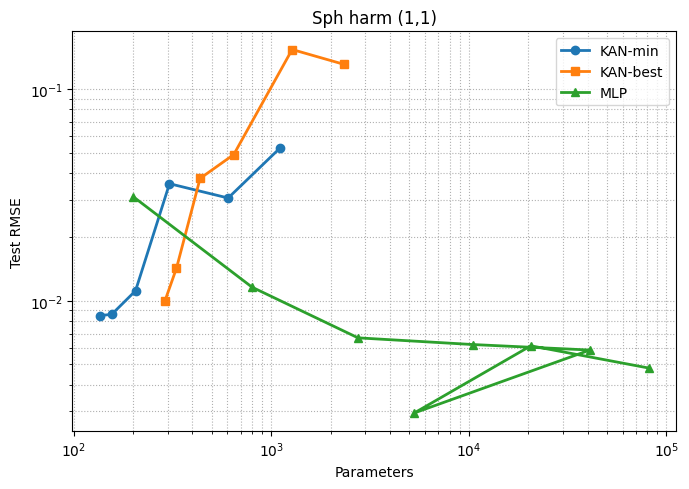

/tmp/ipykernel_19/3274818750.py:106: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  func=lambda x: scipy.special.sph_harm(0, 2, x[:,0], x[:,1]).real,



Benchmark: Sph harm (0,2)

--- Training KAN-min for Sph harm (0,2) ---
Generated 1000 valid samples for Sph harm (0,2)
Y range: [-0.315, 0.631]
Generated 1000 valid samples for Sph harm (0,2)
Y range: [-0.315, 0.631]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.29e-02 | test_loss: 3.24e-02 | reg: 6.01e+00 | : 100%|█| 200/200 [00:16<00:00, 12.05


saving model version 0.1
    params=80, RMSE=1.09e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.63e-01 | test_loss: 4.94e-01 | reg: 6.59e+00 | : 100%|█| 200/200 [00:46<00:00,  4.32


saving model version 0.1
    params=92, RMSE=1.66e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e-02 | test_loss: 1.33e-02 | reg: 5.69e+00 | : 100%|█| 200/200 [00:30<00:00,  6.47


saving model version 0.1
    params=122, RMSE=4.48e-03
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.07e-03 | test_loss: 7.14e-03 | reg: 5.43e+00 | : 100%|█| 200/200 [00:42<00:00,  4.66


saving model version 0.1
    params=182, RMSE=2.40e-03
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.14e-02 | test_loss: 2.84e-02 | reg: 5.38e+00 | : 100%|█| 200/200 [00:18<00:00, 10.86


saving model version 0.1
    params=362, RMSE=9.54e-03
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-01 | test_loss: 5.39e-01 | reg: 5.58e+00 | : 100%|█| 200/200 [00:54<00:00,  3.67


saving model version 0.1
    params=662, RMSE=1.81e-01

--- Training KAN-best for Sph harm (0,2) ---
Generated 1000 valid samples for Sph harm (0,2)
Y range: [-0.315, 0.631]
Generated 1000 valid samples for Sph harm (0,2)
Y range: [-0.315, 0.631]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.19e-02 | test_loss: 2.36e-02 | reg: 5.53e+00 | : 100%|█| 200/200 [00:23<00:00,  8.42


saving model version 0.1
    params=80, RMSE=7.88e-03
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.85e-02 | test_loss: 3.92e-02 | reg: 5.36e+00 | : 100%|█| 200/200 [00:21<00:00,  9.32


saving model version 0.1
    params=92, RMSE=1.31e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.03e-02 | test_loss: 1.94e-02 | reg: 6.12e+00 | : 100%|█| 200/200 [00:30<00:00,  6.48


saving model version 0.1
    params=122, RMSE=6.48e-03
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.06e-03 | test_loss: 9.40e-03 | reg: 5.50e+00 | : 100%|█| 200/200 [00:34<00:00,  5.72


saving model version 0.1
    params=182, RMSE=3.14e-03
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.03e-02 | test_loss: 5.58e-02 | reg: 5.40e+00 | : 100%|█| 200/200 [00:17<00:00, 11.13


saving model version 0.1
    params=362, RMSE=1.86e-02
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [00:54<00:00,  3.67it/s]


saving model version 0.1
    NaNs detected — skipping

--- Training MLP for Sph harm (0,2) ---
Generated 1000 valid samples for Sph harm (0,2)
Y range: [-0.315, 0.631]
Generated 1000 valid samples for Sph harm (0,2)
Y range: [-0.315, 0.631]
  MLP d=2, w=100: params=401, RMSE=9.73e-03
  MLP d=2, w=200: params=801, RMSE=1.21e-02
  MLP d=3, w=100: params=10501, RMSE=8.08e-03
  MLP d=3, w=200: params=41001, RMSE=1.00e-02
  MLP d=4, w=50: params=5301, RMSE=5.71e-03
  MLP d=4, w=100: params=20601, RMSE=4.91e-03
  MLP d=4, w=200: params=81201, RMSE=9.69e-03


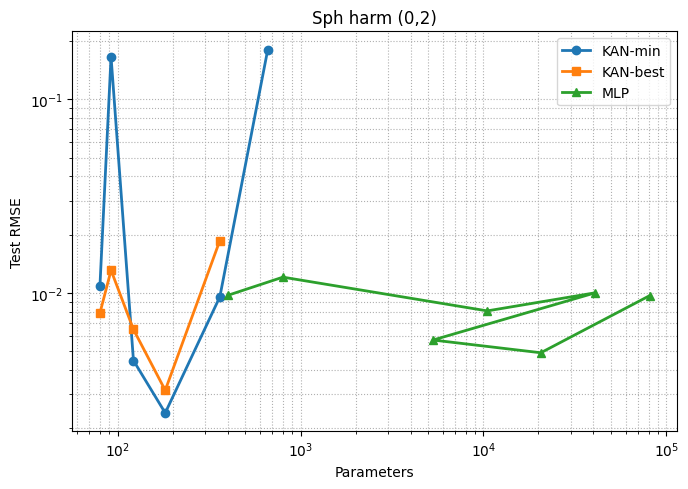

/tmp/ipykernel_19/3274818750.py:114: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  func=lambda x: scipy.special.sph_harm(1, 2, x[:,0], x[:,1]).real,



Benchmark: Sph harm (1,2)

--- Training KAN-min for Sph harm (1,2) ---
Generated 1000 valid samples for Sph harm (1,2)
Y range: [-0.385, 0.384]
Generated 1000 valid samples for Sph harm (1,2)
Y range: [-0.386, 0.385]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.78e-01 | test_loss: 1.95e-01 | reg: 1.01e+01 | : 100%|█| 200/200 [00:53<00:00,  3.74


saving model version 0.1
    params=136, RMSE=3.82e-02
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.22e-02 | test_loss: 5.55e-02 | reg: 1.03e+01 | : 100%|█| 200/200 [00:46<00:00,  4.26


saving model version 0.1
    params=156, RMSE=1.09e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e-01 | test_loss: 1.73e-01 | reg: 9.89e+00 | : 100%|█| 200/200 [00:33<00:00,  5.99


saving model version 0.1
    params=206, RMSE=3.39e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.43e-01 | test_loss: 1.86e-01 | reg: 9.44e+00 | : 100%|█| 200/200 [00:54<00:00,  3.68


saving model version 0.1
    params=306, RMSE=3.63e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.42e-01 | test_loss: 3.75e-01 | reg: 9.81e+00 | : 100%|█| 200/200 [00:55<00:00,  3.60


saving model version 0.1
    params=606, RMSE=7.34e-02
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.48e-02 | test_loss: 4.01e-01 | reg: 9.55e+00 | : 100%|█| 200/200 [00:55<00:00,  3.60


saving model version 0.1
    params=1106, RMSE=7.84e-02

--- Training KAN-best for Sph harm (1,2) ---
Generated 1000 valid samples for Sph harm (1,2)
Y range: [-0.386, 0.381]
Generated 1000 valid samples for Sph harm (1,2)
Y range: [-0.385, 0.386]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.99e-01 | test_loss: 9.98e-01 | reg: 3.81e-01 | : 100%|█| 200/200 [00:26<00:00,  7.45


saving model version 0.1
    params=164, RMSE=1.92e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.98e-01 | reg: 3.36e-01 | : 100%|█| 200/200 [00:40<00:00,  4.97


saving model version 0.1
    params=188, RMSE=1.92e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.60e-01 | test_loss: 3.74e-01 | reg: 1.13e+01 | : 100%|█| 200/200 [01:19<00:00,  2.51


saving model version 0.1
    params=248, RMSE=7.20e-02
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.98e-01 | reg: 8.41e-01 | : 100%|█| 200/200 [00:31<00:00,  6.27


saving model version 0.1
    params=368, RMSE=1.92e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.70e-01 | test_loss: 9.53e-01 | reg: 1.11e+01 | : 100%|█| 200/200 [01:20<00:00,  2.48


saving model version 0.1
    params=728, RMSE=1.84e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.41e-01 | test_loss: 1.09e+00 | reg: 1.23e+01 | : 100%|█| 200/200 [01:18<00:00,  2.56


saving model version 0.1
    params=1328, RMSE=2.11e-01

--- Training MLP for Sph harm (1,2) ---
Generated 1000 valid samples for Sph harm (1,2)
Y range: [-0.386, 0.381]
Generated 1000 valid samples for Sph harm (1,2)
Y range: [-0.385, 0.386]
  MLP d=2, w=100: params=401, RMSE=2.60e-02
  MLP d=2, w=200: params=801, RMSE=2.41e-02
  MLP d=3, w=50: params=2751, RMSE=2.62e-02
  MLP d=3, w=100: params=10501, RMSE=2.59e-02
  MLP d=3, w=200: params=41001, RMSE=1.24e-02
  MLP d=4, w=50: params=5301, RMSE=1.90e-02
  MLP d=4, w=100: params=20601, RMSE=2.76e-02
  MLP d=4, w=200: params=81201, RMSE=1.32e-02


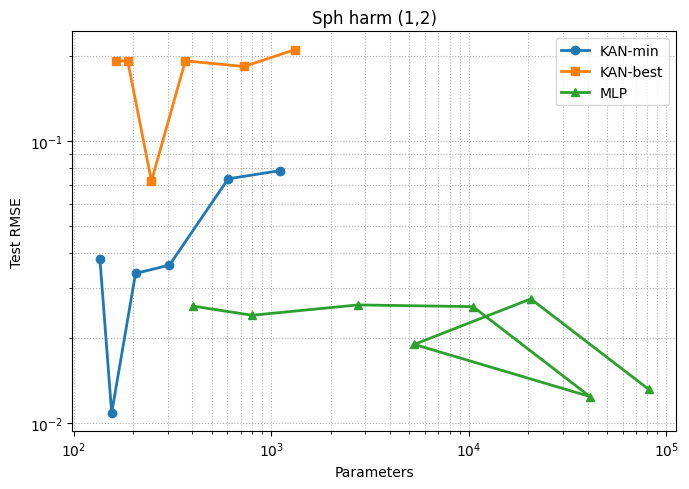

/tmp/ipykernel_19/3274818750.py:122: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  func=lambda x: scipy.special.sph_harm(2, 2, x[:,0], x[:,1]).real,



Benchmark: Sph harm (2,2)

--- Training KAN-min for Sph harm (2,2) ---
Generated 1000 valid samples for Sph harm (2,2)
Y range: [-0.385, 0.386]
Generated 1000 valid samples for Sph harm (2,2)
Y range: [-0.386, 0.386]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.95e-01 | reg: 1.01e-01 | : 100%|█| 200/200 [00:20<00:00,  9.56


saving model version 0.1
    params=136, RMSE=1.67e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.97e-02 | test_loss: 6.92e-02 | reg: 9.09e+00 | : 100%|█| 200/200 [00:53<00:00,  3.72


saving model version 0.1
    params=156, RMSE=1.16e-02
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.84e-02 | test_loss: 4.93e-02 | reg: 9.32e+00 | : 100%|█| 200/200 [00:48<00:00,  4.16


saving model version 0.1
    params=206, RMSE=8.26e-03
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.88e-01 | test_loss: 2.55e-01 | reg: 1.03e+01 | : 100%|█| 200/200 [00:55<00:00,  3.60


saving model version 0.1
    params=306, RMSE=4.27e-02
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.33e-01 | test_loss: 3.31e-01 | reg: 8.95e+00 | : 100%|█| 200/200 [00:54<00:00,  3.67


saving model version 0.1
    params=606, RMSE=5.55e-02
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.89e-02 | test_loss: 3.95e-01 | reg: 8.65e+00 | : 100%|█| 200/200 [00:55<00:00,  3.60


saving model version 0.1
    params=1106, RMSE=6.62e-02

--- Training KAN-best for Sph harm (2,2) ---
Generated 1000 valid samples for Sph harm (2,2)
Y range: [-0.385, 0.385]
Generated 1000 valid samples for Sph harm (2,2)
Y range: [-0.385, 0.386]
  Grid = 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.61e-01 | reg: 4.34e-01 | : 100%|█| 200/200 [00:27<00:00,  7.18


saving model version 0.1
    params=374, RMSE=1.70e-01
  Grid = 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.62e-01 | reg: 6.59e-01 | : 100%|█| 200/200 [00:43<00:00,  4.63


saving model version 0.1
    params=428, RMSE=1.70e-01
  Grid = 10
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.61e-01 | reg: 1.64e+00 | : 100%|█| 200/200 [00:38<00:00,  5.18


saving model version 0.1
    params=563, RMSE=1.70e-01
  Grid = 20
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.00e+00 | test_loss: 9.62e-01 | reg: 9.13e-01 | : 100%|█| 200/200 [00:33<00:00,  5.95


saving model version 0.1
    params=833, RMSE=1.70e-01
  Grid = 50
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.99e-01 | test_loss: 9.62e-01 | reg: 3.27e+00 | : 100%|█| 200/200 [00:46<00:00,  4.33


saving model version 0.1
    params=1643, RMSE=1.70e-01
  Grid = 100
checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 200/200 [01:49<00:00,  1.82it/s]


saving model version 0.1
    NaNs detected — skipping

--- Training MLP for Sph harm (2,2) ---
Generated 1000 valid samples for Sph harm (2,2)
Y range: [-0.385, 0.385]
Generated 1000 valid samples for Sph harm (2,2)
Y range: [-0.385, 0.386]
  MLP d=2, w=50: params=201, RMSE=3.81e-02
  MLP d=2, w=100: params=401, RMSE=3.09e-02
  MLP d=2, w=200: params=801, RMSE=2.76e-02
  MLP d=3, w=50: params=2751, RMSE=2.19e-02
  MLP d=3, w=200: params=41001, RMSE=2.41e-02
  MLP d=4, w=50: params=5301, RMSE=2.38e-02
  MLP d=4, w=200: params=81201, RMSE=2.08e-02


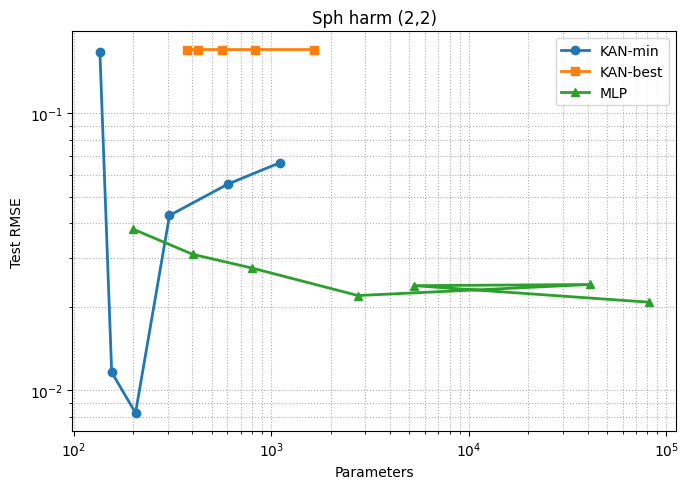

In [10]:
for bench in BENCHMARKS:
    print("\n" + "="*60)
    print(f"Benchmark: {bench['name']}")
    print("="*60)
    
    kanmin_p, kanmin_r = train_kan_shape(
        bench, bench["kan_min"], label="KAN-min"
    )
    kanbest_p, kanbest_r = train_kan_shape(
        bench, bench["kan_best"], label="KAN-best"
    )
    mlp_res = train_mlp(bench)
    
    # Plot
    plt.figure(figsize=(7,5))
    if kanmin_p:
        plt.loglog(kanmin_p, kanmin_r, 'o-', label="KAN-min", lw=2)
    if kanbest_p:
        plt.loglog(kanbest_p, kanbest_r, 's-', label="KAN-best", lw=2)
    if mlp_res:
        p, r = zip(*mlp_res)
        plt.loglog(p, r, '^-', label="MLP", lw=2)
    plt.xlabel("Parameters")
    plt.ylabel("Test RMSE")
    plt.title(bench["name"])
    plt.legend()
    plt.grid(True, which="both", ls=":")
    plt.tight_layout()
    plt.show()
